# QMBS

In [188]:
import numpy as np
from qutip import *
from matplotlib import pyplot as plt

In [189]:
N=16

In [204]:
state_list = ([basis(2, 1)] + [basis(2, 0)] + [basis(2, 0)] + [basis(2, 1)])* (int(N/4))
state_thermal = ([basis(2,1)]*int(N/2) + [basis(2,0)]*int(N/2))
psi0 = tensor(state_list)
psi_thermal = tensor(state_thermal)

# Energy splitting term
omega = 2 * np.pi * np.ones(N)

# Interaction coefficients
Ja = 0.3 * np.pi * np.ones(N)
Je = 0.2 * np.pi * np.ones(N)


In [191]:
sx_list, sy_list, sz_list, sm_list,sp_list = [], [], [], [], []
for i in range(N):
    op_list = [qeye(2)] * N
    op_list[i] = sigmax()
    sx_list.append(tensor(op_list))
    op_list[i] = sigmay()
    sy_list.append(tensor(op_list))
    op_list[i] = sigmaz()
    sz_list.append(tensor(op_list))
    op_list[i] = sigmap()
    sp_list.append(tensor(op_list))
    op_list[i] = sigmam()
    sm_list.append(tensor(op_list))

# Hamiltonian - transition frequenmcy term
H = 0
for i in range(N):
    H += 0.5 * omega[i] * sp_list[i]*sm_list[i]

# Interaction terms
for n in range(N - 1):
    if n%2 ==0:
        H += -0.5 * Ja[n] * sp_list[n] * sm_list[n + 1]
        H += -0.5 * Ja[n] * sm_list[n] * sp_list[n + 1]
    else:
        H += -0.5 * Je[n] * sp_list[n] * sm_list[n + 1]
        H += -0.5 * Je[n] * sm_list[n] * sp_list[n + 1]
        
# Cross coupling terms



In [206]:
times = np.linspace(0,25,100)
result = sesolve(H,psi0,times)
resultsThermal = sesolve(H,psi_thermal,times)
states = [ result.states]

In [220]:
VNEntropy=[]
thermalVN = []
thermalfidelity=[]
fourfidelity = []
rho0=ptrace(psi0,[0,1,2,3])
rho0_thermal = ptrace(psi_thermal,[0,1,2,3])
for Psi_T in result.states:
    rho=ptrace(Psi_T,[0,1,2,3])
    VNEntropy.append(entropy_vn(rho))
    fourfidelity.append(fidelity(rho0,rho))
for Psi_T in resultsThermal.states:
    rho=ptrace(Psi_T,[0,1,2,3])
    thermalVN.append(entropy_vn(rho))
    thermalfidelity.append(fidelity(rho0_thermal,rho))
    

In [212]:
exp_sz_t = expect(sz_list, result.states)
exp_sz_0 = expect(sz_list,psi0)
exp_sz_t2=[]
for i in range(len(exp_sz_0)):
    exp_sz_t2.append(exp_sz_0[i]*exp_sz_t[i])
imbalance =  1/N* sum(exp_sz_t2)

In [213]:
fidelitylist = []

for i in range(len(result.times)):
    fidelitylist.append(np.vdot(result.states[0],result.states[i])*np.conj(np.vdot(result.states[0],result.states[i])))

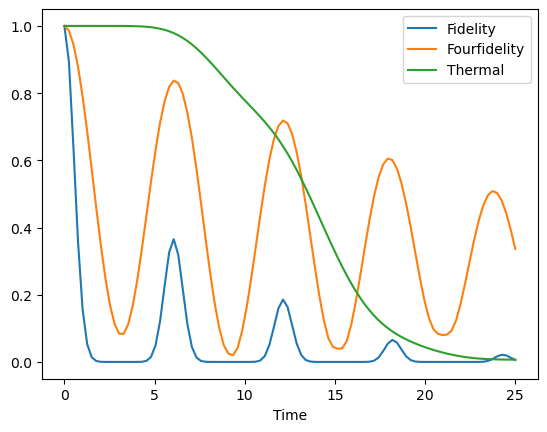

In [221]:
plt.plot(times,fidelitylist,label = 'Fidelity')
plt.plot(times,fourfidelity,label='Fourfidelity')
plt.plot(times, thermalfidelity,label='Thermal')
plt.xlabel('Time')
plt.legend()


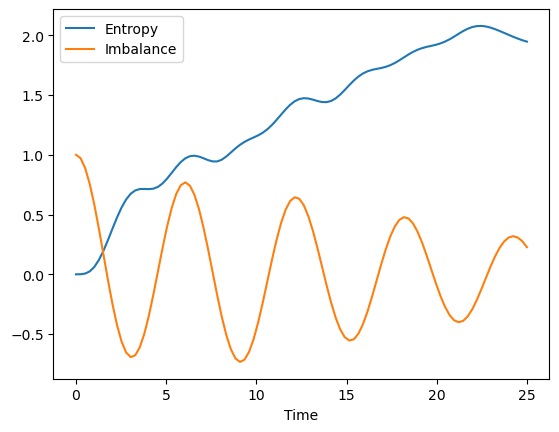

In [222]:
plt.plot(times,VNEntropy,label = 'Entropy')
plt.plot(times,imbalance, label = 'Imbalance')
plt.xlabel('Time')
plt.legend()

In [197]:
from scipy.fft import fft,fftfreq

In [198]:
intensity_imbalance = fft(imbalance,n=100)

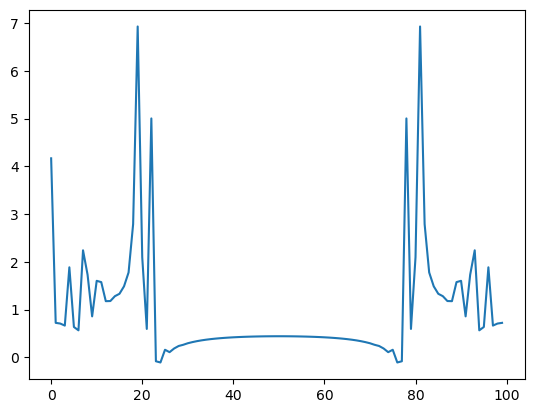

In [199]:
plt.plot(intensity_imbalance)

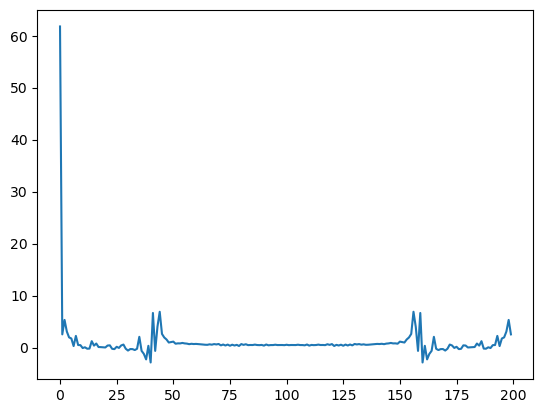

In [200]:
intensity_fidelity = fft(fourfidelity)
plt.plot(intensity_fidelity)

In [201]:
psi0


Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape = (65536, 1), type = ket
Qobj data =
  (39321, 0)	(1+0j)